In [61]:
### 04/19 update
### normalize the perturbed and unperturbed beams so that the total power is equal

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.stats import binned_statistic
import scipy.optimize as opt
mpl.rc('xtick', direction='in', top=True)
mpl.rc('ytick', direction='in', right=True)
mpl.rc('xtick.minor', visible=True)
mpl.rc('ytick.minor', visible=True)
plt.rcParams['font.size'] = 15
from mycolorpy import colorlist as mcp
%run Fraunhofer
%run ErrMask

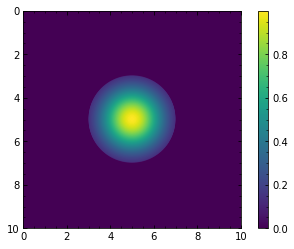

In [2]:
screen = {}
screen['N'] = 4096
screen['D'] = 10
Initialize(screen)
center = (screen['D']/2, screen['D']/2)
MultByGaussian(screen, center, 1.0)
InCircle(screen, center, 2.0)

ScreenFFT(screen)

lam = 0.002 #m wavelength
kphot = 2*np.pi/lam
thetamaxdeg = 3.0
thetamax = 2*np.pi/180. # 2 degrees in radians
theta_vec = np.linspace(-thetamax,thetamax,512) 
#II0 = Project_I_on_thetagrid(theta_vec,screen,lam) 
theta_vec = np.linspace(0, 2*thetamax, 512)


plt.imshow(screen['E'],extent=(0,screen['D'],screen['D'],0))
plt.colorbar()

rms =  0.1771501484502546
total V^2/Hz^2 =  0.03138217509594724
RMS^2 =  0.03138217509594724
average error is  4.439198070499837e-05
leakage (error^2) = 0.0006472554747048542
172212038784.43436
172212038784.43433


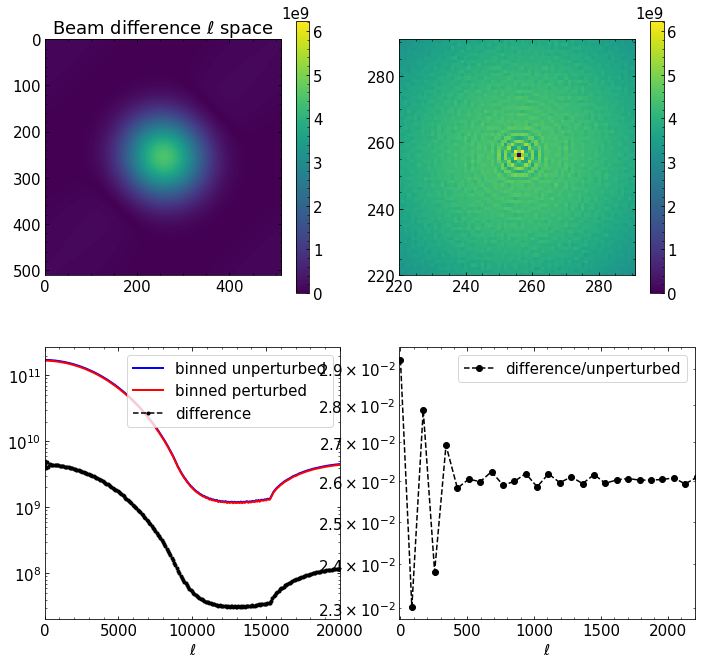

In [56]:
### generate an unperturbed and a perturbed screen --> normalize: (sum(II0) = sum(II1))

N_screen = 1500
N_theta = 512
D = 10.0
sigma = 1.0
maxdeg = 3.0
trunc = 'y'
option = 'amp'
radius = 2.0
amp = 1.0
kin = 20
kout = kin+5

def gaussian(x, A, sigma, x0): 
    g = A*np.exp(-(x-x0)**2/(2*sigma**2))
    return(g)

def analytical(l, sigma): # blm
    fft = bin_mean0.max()* np.exp(-l*(l+1)*sigma**2/2)
    return(fft)

# unperturbed perfect gaussian create E screen [m]
screen = {}
screen['N'] = N_screen
screen['D'] = D
Initialize(screen)
center = (screen['D']/2, screen['D']/2)
MultByGaussian(screen, center, sigma)
if trunc=='y':
    InCircle(screen, center, 2.0)
ScreenFFT(screen)

# interpolation in sky intensity [rad] (unperturbed beam)
lam = 0.002 #mm wavelength
thetamaxdeg = maxdeg
thetamax = thetamaxdeg*np.pi/180. # in radians
theta_vec = np.linspace(-thetamax,thetamax,N_theta) 
II0 = Project_I_on_thetagrid(theta_vec,screen,lam)   # unperturbed
fft_I0 = np.abs(np.fft.fftshift(np.fft.fft2(np.fft.fftshift(II0)))) # in ell space
theta_vec = np.linspace(0,2*thetamax,N_theta) #rad

#calculate ell
n = theta_vec.shape[0]
dl = 2*np.pi/theta_vec.max() # dl in 1/rad space
l_vec = np.fft.fftshift(dl * np.fft.fftfreq(n)*n)
(l_x, l_y) = np.meshgrid(l_vec,l_vec) # 1/rad 
l = np.sqrt(l_x**2 + l_y**2)

        
# perturbed E screen
screen1 = {}
screen1['N'] = N_screen
screen1['D'] = D
Initialize(screen1)
MultByGaussian(screen1, center, sigma)
if trunc=='y':
    InCircle(screen1, center, 2.0)
    
if option=='phase':
    emap_E = filter_annulus_phase(screen1, amp, kin, kout)
elif option=='amp':
    emap_E = filter_annulus_amp(screen1, amp, kin, kout)
else: print('Choose phase or amplitude errors')
print('rms = ', np.sqrt(np.mean(emap_E**2)))

ScreenFFT(screen1)

# interpolate the perturbed beam 
theta_vec = np.linspace(-thetamax,thetamax,N_theta) 
II1 = Project_I_on_thetagrid(theta_vec, screen1, lam) # perturbed
II1 = II1 * (np.sum(II0)/np.sum(II1)) ### normalization
# shift the beam from being centered at theta=0 to theta=thetamax so that the beam spans from 0 deg to 2*thetamax deg
theta_vec = np.linspace(0,2*thetamax,N_theta) #rad

# FT of sky intensity
I_diff = II1 - II0 # take the difference in theta space (sky)
fft_Idiff = np.abs(np.fft.fftshift(np.fft.fft2(np.fft.fftshift(I_diff)))) # FFT the difference to ell space
fft_I1 = np.abs(np.fft.fftshift(np.fft.fft2(np.fft.fftshift(II1)))) # in ell space

# average (FT of II0)^2 radially 
bin_edges = np.linspace(0,l.max(),int(len(theta_vec)/2))
l_flatten = l.flatten()
fft_numerical0 = fft_I0.flatten()
fft_numerical1 = fft_I1.flatten()
fft_numerical_diff = fft_Idiff.flatten()
bin_mean0, bin_edge, bin_num = binned_statistic(l_flatten, fft_numerical0, statistic='mean', bins=bin_edges) 
bin_mean1, bin_edge, bin_num = binned_statistic(l_flatten, fft_numerical1, statistic='mean', bins=bin_edges) # bin_mean is the binned numerical beam
bin_mean_diff, bin_edge, bin_num = binned_statistic(l_flatten, fft_numerical_diff, statistic='mean', bins=bin_edges) # bin the beam difference
l_vec = bin_edges[0:-1] # ell 1D vector

beam_diff_rela = bin_mean_diff/bin_mean0 # relative beam difference
error = np.mean(beam_diff_rela[1:3]) #for maxdeg=3.0
#error = np.mean(beam_diff_rela[4])

# Calculates the noise level in fourier space (V^2/Hz)
emap_fft = np.fft.fftshift(np.fft.fft2(np.fft.fftshift(emap_E))) # scaled error map in fourier space
norm_fft = np.abs(emap_fft**2)/screen1['dk']**2/screen1['N']**4 # V^2/Hz^2

idx = np.where((screen1['kap']<kout) & (screen1['kap']>kin)) # inside the filter
avg_fft = np.mean(norm_fft[idx]) # V^2/Hz^2
total_Vf = np.sum(norm_fft)*screen['dk']**2
rms_sq = np.abs(rms(emap_E)**2)
print('total V^2/Hz^2 = ',total_Vf)
print('RMS^2 = ', rms_sq)
print('average error is ', avg_fft)
print('leakage (error^2) = {}'.format(error**2))


print(np.sum(II0))
print(np.sum(II1))

# plot the difference
fig = plt.figure(figsize=(18,11))
plt.subplot(2,3,1) # plot the beam difference fft_Idiff - take the difference in theta space, then FFT
plt.imshow(fft_Idiff, interpolation=None) 
plt.colorbar()
plt.title(r'Beam difference $\ell$ space')
plt.subplot(2,3,2) # plot the beam difference fft_Idiff and zoom in at the center 
plt.imshow(fft_Idiff, interpolation=None) 
plt.colorbar()
plt.xlim(int(N_theta*0.43),int(N_theta*0.57))
plt.ylim(int(N_theta*0.43),int(N_theta*0.57))
plt.subplot(2,3,4) # plot the power spectrum of the numerical and analytical beam in ell space respectively, and compare to the theory
plt.plot(l_vec,bin_mean0,color='blue', lw=2, label='binned unperturbed') 
plt.plot(l_vec,bin_mean1,color='red', lw=2, label='binned perturbed')
plt.xlabel(r'$\ell$')
#plt.plot(bin_edges, analytical(bin_edges, fit[1]), color='black', lw=3, ls=':', label='analytical blm')
plt.xlim(0,2e4)
plt.legend()
plt.subplot(2,3,4) # plot the power spectrum of the beam difference in log scale - take the difference and then FFT
plt.semilogy(l_vec,bin_mean_diff, 'o--', ms=3, color='black', label='difference') 
plt.xlabel(r'$\ell$')
plt.legend()
#plt.xlim(-10,2e4)
plt.subplot(2,3,5) # # plot the power spectrum of the relative beam difference in log scale by dividing the beam difference by the numerical unperturbed beam
plt.semilogy(l_vec,bin_mean_diff/bin_mean0,'o--', color='black', label='difference/unperturbed') 
plt.xlabel(r'$\ell$')
plt.legend()
plt.xlim(-10,2200)
plt.legend()
plt.show()

#plt.savefig('/Users/zhaoyuhuai/Desktop/SeniorProj/Plots/beam_diff_5.png', dpi=500)

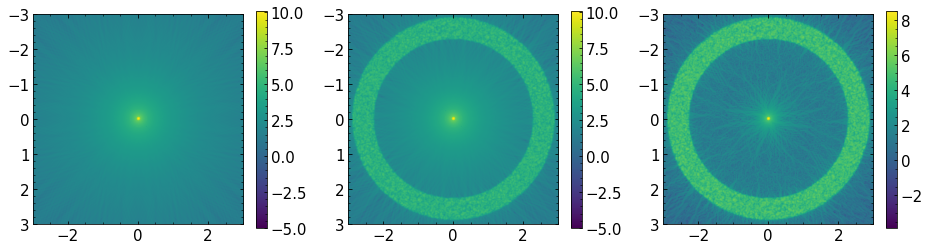

In [57]:

fig = plt.figure(figsize=(16,4))
plt.subplot(1,3,1)
plt.imshow(np.log10(np.abs(II0)),vmin=-5,interpolation = None,extent=[-thetamaxdeg,thetamaxdeg,thetamaxdeg,-thetamaxdeg])
plt.colorbar()

plt.subplot(1,3,2)
plt.imshow(np.log10(np.abs(II1)),vmin=-5,interpolation = None,extent=[-thetamaxdeg,thetamaxdeg,thetamaxdeg,-thetamaxdeg])
plt.colorbar()

plt.subplot(1,3,3)
plt.imshow(np.log10(np.abs(I_diff)),interpolation = None,extent=[-thetamaxdeg,thetamaxdeg,thetamaxdeg,-thetamaxdeg])
plt.colorbar()


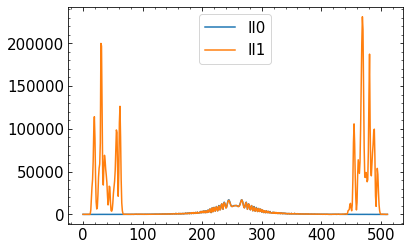

In [58]:
# take a horizontal slice 
plt.plot(II0[216], label='II0')
plt.plot(II1[216], label='II1')
# plt.xlim(100,400)
# plt.ylim(0,1e5)
plt.legend();

In [59]:
print(II1.max(), II0.max())

13106720294.014814 13457147821.942762


# Generate thesis plots 

In [30]:
screen = {}
screen['N'] = 1024
screen['D'] = 10
Initialize(screen)
center = (screen['D']/2, screen['D']/2)
MultByGaussian(screen, center, 1.0)
InCircle(screen, center, 2.0)
emap_E = filter_annulus_amp(screen, 5.0, 3, 6)

In [31]:
screen1 = {}
screen1['N'] = 1024
screen1['D'] = 10
Initialize(screen1)
center = (screen1['D']/2, screen1['D']/2)
MultByGaussian(screen1, center, 1.0)
InCircle(screen1, center, 2.0)
emap_E = filter_annulus_phase(screen1, 5.0, 3, 6)

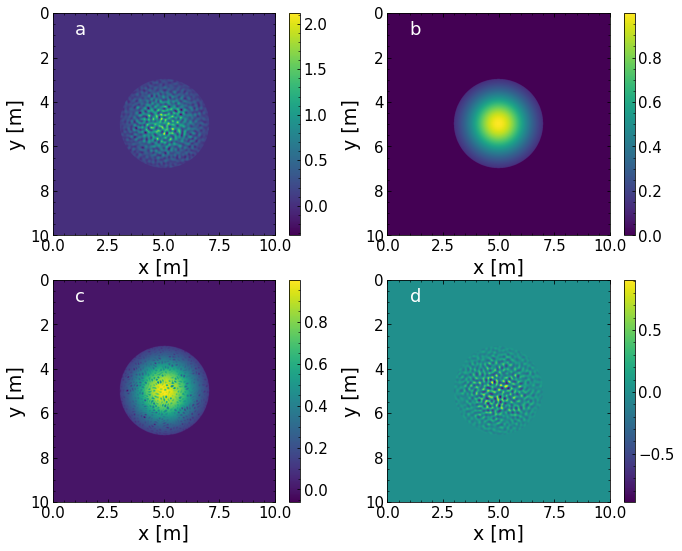

In [34]:
### Fig.6
fig = plt.figure(figsize=(11,9))
plt.subplot(2,2,1)
plt.imshow(screen['E'], extent=(0,10,10,0))
plt.colorbar()
plt.xlabel('x [m]', fontsize=19)
plt.ylabel('y [m]', fontsize=19)
plt.text(1,1,'a', color='white', size=18)
plt.subplot(2,2,2)
plt.imshow(np.abs(screen1['E']), extent=(0,10,10,0))
plt.colorbar()
plt.xlabel('x [m]', fontsize=19)
plt.ylabel('y [m]', fontsize=19)
plt.text(1,1,'b', color='white', size=18)
plt.subplot(2,2,3)
plt.imshow(np.real(screen1['E']), extent=(0,10,10,0))
plt.colorbar()
plt.xlabel('x [m]', fontsize=19)
plt.ylabel('y [m]', fontsize=19)
plt.text(1,1,'c', color='white', size=18)
plt.subplot(2,2,4)
plt.imshow(np.imag(screen1['E']), extent=(0,10,10,0))
plt.colorbar()
plt.xlabel('x [m]', fontsize=19)
plt.ylabel('y [m]', fontsize=19)
plt.text(1,1,'d', color='white', size=18)
plt.savefig('/Users/zhaoyuhuai/Desktop/SeniorProj/Thesis/Err_ampphase_h.png', bbox_inches='tight', dpi=600)

Text(0, 0.5, 'y [m]')

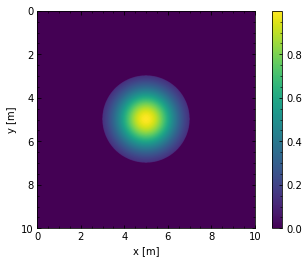

In [16]:
plt.imshow(np.abs(screen1['E']), extent=(0,10,10,0))
plt.colorbar()
plt.xlabel('x [m]')
plt.ylabel('y [m]')

rms =  0.015851250674723514
beam_diff / perfect beam =  0.00021095438711667028
V^2/Hz^2 =  0.00025126214795292284
RMS^2 =  0.0002512621479529227
average error is  9.520990619795571e-07
leakage (error^2) = 4.4501753443769985e-08
37377104535.667336
37377104535.66733


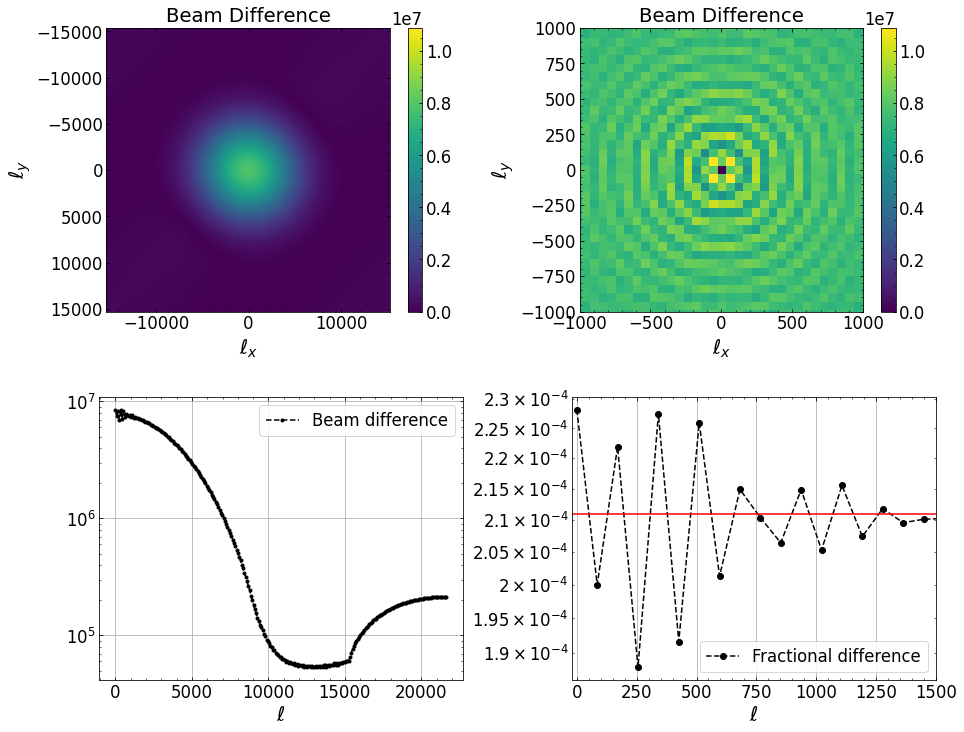

In [24]:
N_screen = 1024
N_theta = 512
D = 10.0
sigma = 1.0
maxdeg = 3.0
trunc = 'y'
option = 'amp'
radius = 2.0
amp = 0.1
kin = 20
kout = kin+2

def gaussian(x, A, sigma, x0): 
    g = A*np.exp(-(x-x0)**2/(2*sigma**2))
    return(g)

def analytical(l, sigma): # blm
    fft = bin_mean0.max()* np.exp(-l*(l+1)*sigma**2/2)
    return(fft)

# unperturbed perfect gaussian create E screen [m]
screen = {}
screen['N'] = N_screen
screen['D'] = D
Initialize(screen)
center = (screen['D']/2, screen['D']/2)
MultByGaussian(screen, center, sigma)
if trunc=='y':
    InCircle(screen, center, 2.0)
ScreenFFT(screen)

# interpolation in sky intensity [rad] (unperturbed beam)
lam = 0.002 #mm wavelength
thetamaxdeg = maxdeg
thetamax = thetamaxdeg*np.pi/180. # in radians
theta_vec = np.linspace(-thetamax,thetamax,N_theta) 
II0 = Project_I_on_thetagrid(theta_vec,screen,lam)   # unperturbed
fft_I0 = np.abs(np.fft.fftshift(np.fft.fft2(np.fft.fftshift(II0)))) # in ell space
theta_vec = np.linspace(0,2*thetamax,N_theta) #rad

#calculate ell
n = theta_vec.shape[0]
dl = 2*np.pi/theta_vec.max() # dl in 1/rad space
l_vec = np.fft.fftshift(dl * np.fft.fftfreq(n)*n)
(l_x, l_y) = np.meshgrid(l_vec,l_vec) # 1/rad 
l = np.sqrt(l_x**2 + l_y**2)

        
# perturbed E screen
screen1 = {}
screen1['N'] = N_screen
screen1['D'] = D
Initialize(screen1)
MultByGaussian(screen1, center, sigma)
if trunc=='y':
    InCircle(screen1, center, 2.0)
    
if option=='phase':
    emap_E = filter_annulus_phase(screen1, amp, kin, kout)
elif option=='amp':
    emap_E = filter_annulus_amp(screen1, amp, kin, kout)
else: print('Choose phase or amplitude errors')
print('rms = ', np.sqrt(np.mean(emap_E**2)))

ScreenFFT(screen1)

# interpolate the perturbed beam 
theta_vec = np.linspace(-thetamax,thetamax,N_theta) 
II1 = Project_I_on_thetagrid(theta_vec, screen1, lam) # perturbed
II1 = II1 * (np.sum(II0)/np.sum(II1))
# shift the beam from being centered at theta=0 to theta=thetamax so that the beam spans from 0 deg to 2*thetamax deg
theta_vec = np.linspace(0,2*thetamax,N_theta) #rad

# FT of sky intensity
I_diff = II0 - II1 # take the difference in theta space (sky)
fft_Idiff = np.abs(np.fft.fftshift(np.fft.fft2(np.fft.fftshift(I_diff)))) # FFT the difference to ell space
fft_I1 = np.abs(np.fft.fftshift(np.fft.fft2(np.fft.fftshift(II1)))) # in ell space

# average (FT of II0)^2 radially 
bin_edges = np.linspace(0,l.max(),int(len(theta_vec)/2))
l_flatten = l.flatten()
fft_numerical0 = fft_I0.flatten()
fft_numerical1 = fft_I1.flatten()
fft_numerical_diff = fft_Idiff.flatten()
bin_mean0, bin_edge, bin_num = binned_statistic(l_flatten, fft_numerical0, statistic='mean', bins=bin_edges) 
bin_mean1, bin_edge, bin_num = binned_statistic(l_flatten, fft_numerical1, statistic='mean', bins=bin_edges) # bin_mean is the binned numerical beam
bin_mean_diff, bin_edge, bin_num = binned_statistic(l_flatten, fft_numerical_diff, statistic='mean', bins=bin_edges) # bin the beam difference
l_vec = bin_edges[0:-1] # ell 1D vector

beam_diff_rela = bin_mean_diff/bin_mean0 # relative beam difference
#error = np.mean(beam_diff_rela[1:3]) #for maxdeg=3.0
error = np.mean(beam_diff_rela[(l_vec>=49)&(l_vec<=251)]) # average the beam difference between 0<l<500
print('beam_diff / perfect beam = ', error)

# Calculates the noise level in fourier space (V^2/Hz)
emap_fft = np.fft.fftshift(np.fft.fft2(np.fft.fftshift(emap_E))) # scaled error map in fourier space
norm_fft = np.abs(emap_fft**2)/screen1['dk']**2/screen1['N']**4 # V^2/Hz^2

idx = np.where((screen1['kap']<kout) & (screen1['kap']>kin)) # inside the filter
avg_fft = np.mean(norm_fft[idx]) # V^2/Hz^2
total_Vf = np.sum(norm_fft)*screen['dk']**2
rms_sq = np.abs(rms(emap_E)**2)
print('V^2/Hz^2 = ',total_Vf)
print('RMS^2 = ', rms_sq)
print('average error is ', avg_fft)
print('leakage (error^2) = {}'.format(error**2))


print(np.sum(II0))
print(np.sum(II1))
# plot the difference
plt.rcParams['font.size'] = 16.5
fig = plt.figure(figsize=(15,12))
#fig.tight_layout(pad=5.0)
plt.subplots_adjust(wspace=0.3,
                    hspace=0.3)

plt.subplot(2,2,1) # plot the beam difference fft_Idiff and zoom in at the center 
plt.imshow(fft_Idiff, interpolation=None, extent=(l_x.min(), l_x.max(), l_y.max(), l_y.min())) 
#plt.imshow(fft_Idiff, interpolation=None) 
plt.colorbar()
plt.xlabel(r'$\ell_x$', fontsize=20)
plt.ylabel(r'$\ell_y$', fontsize=20)
plt.title('Beam Difference')

plt.subplot(2,2,2) # plot the beam difference fft_Idiff and zoom in at the center 
plt.imshow(fft_Idiff, interpolation=None, extent=(l_x.min(), l_x.max(), l_y.max(), l_y.min())) 
#plt.imshow(fft_Idiff, interpolation=None) 
plt.colorbar()
plt.xlabel(r'$\ell_x$', fontsize=20)
plt.ylabel(r'$\ell_y$', fontsize=20)
plt.xlim(-1000,1000)
plt.ylim(-1000,1000)
plt.title('Beam Difference')

plt.subplot(2,2,3) # plot the power spectrum of the beam difference in log scale - take the difference and then FFT
plt.semilogy(l_vec,bin_mean_diff, 'o--', ms=3, color='black', label='Beam difference') 
plt.xlabel(r'$\ell$', fontsize=20)
plt.legend()
plt.grid()
#plt.xlim(-10,2e4)

plt.subplot(2,2,4) # # plot the power spectrum of the relative beam difference in log scale by dividing the beam difference by the numerical unperturbed beam
plt.semilogy(l_vec, beam_diff_rela,'o--', color='black', label='Fractional difference')
#plt.plot([], [], ' ', label="                          ")
plt.xlabel(r'$\ell$', fontsize=20)
plt.axhline(error, color='red')
plt.xlim(-20,1500)
#plt.ylim(1e-4, 3e-4)
plt.legend()
#plt.legend(bbox_to_anchor=(0.1, 0.8),loc="lower left", framealpha=0.05)
plt.grid()
#plt.text(450, 3.88e-4, '= beam difference / perfect beam')

#plt.savefig('/Users/zhaoyuhuai/Desktop/SeniorProj/Thesis/beam_diff.png')

## thesis plot - beam window difference

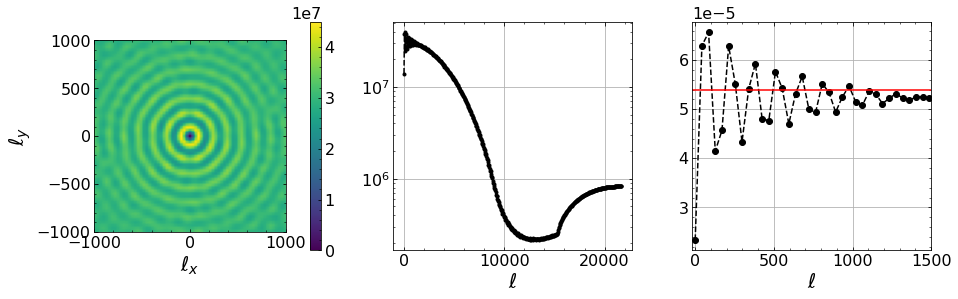

In [16]:
### Fig.8
plt.rcParams['font.size'] = 16
fig = plt.figure(figsize=(15,4.2))
plt.subplots_adjust(wspace=0.25, hspace=0.3)

ax1 = fig.add_subplot(1,3,1)
#fig.tight_layout(pad=5.0)
ax1.imshow(fft_Idiff, interpolation=None, extent=(l_x.min(), l_x.max(), l_y.max(), l_y.min())) 
#plt.imshow(fft_Idiff, interpolation=None) 
#ax1.set_colorbar()
ax1.set_xlabel(r'$\ell_x$', fontsize=20)
ax1.set_ylabel(r'$\ell_y$', fontsize=20)
ax1.set_xlim(-1000,1000)
ax1.set_ylim(-1000,1000)
#ax1.set_title('Beam Difference')
#pcm = ax.pcolormesh(fft_Idiff)
fig.colorbar(pcm, ax=ax1, anchor=(0.5, 0.5))

ax2 = fig.add_subplot(1,3,2)
ax2.semilogy(l_vec,bin_mean_diff, 'o--', ms=3, color='black', label='Beam difference') 
ax2.set_xlabel(r'$\ell$', fontsize=20)
#plt.legend()
ax2.grid()
#plt.xlim(-10,2e4)

ax3 = fig.add_subplot(1,3,3)
ax3.plot(l_vec, beam_diff_rela,'o--', color='black', label='Fractional difference')
plt.ticklabel_format(axis='y', style='sci', scilimits=(-3,-2))
ax3.set_xlabel(r'$\ell$', fontsize=20)
plt.axhline(error, color='red')
ax3.set_xlim(-20,1500)
ax3.grid()

plt.savefig('/Users/zhaoyuhuai/Desktop/SeniorProj/Thesis/beam_diff_h.png', bbox_inches='tight', dpi=600)


# plot Leakage level vs. k, fix error in k space

after normalizing beam, and averaging over 50<l<250

[ 1.  4.  7. 10. 13. 16. 19. 22. 25. 28. 31. 34. 37. 40. 43. 46. 49. 52.
 55. 58. 61. 64. 67. 70.] [1.         0.25       0.14285714 0.1        0.07692308 0.0625
 0.05263158 0.04545455 0.04       0.03571429 0.03225806 0.02941176
 0.02702703 0.025      0.02325581 0.02173913 0.02040816 0.01923077
 0.01818182 0.01724138 0.01639344 0.015625   0.01492537 0.01428571]
[ 1.  5.  9. 13. 17. 21. 25. 29. 33. 37. 41. 45. 49.] [1.         0.2        0.11111111 0.07692308 0.05882353 0.04761905
 0.04       0.03448276 0.03030303 0.02702703 0.02439024 0.02222222
 0.02040816]


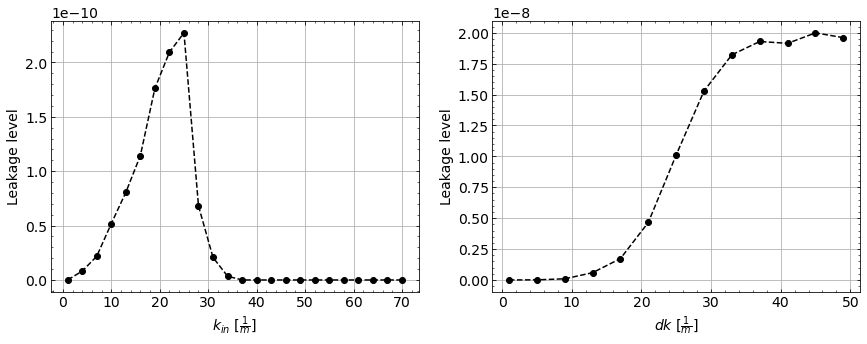

In [36]:
### fix k_in, vary dk (amplitude error = 0.1)
fig = plt.figure(figsize=(14.5,5))
(k, err) = np.loadtxt('Gemmas-CMB/Beam/data/LeakvsK_amp0.1.csv', unpack=True, usecols=(0,1))
x = 1/k # spacial scale corresponding to k_in
print(k, x)
plt.subplot(1,2,1)
plt.plot(k,err,'o--', color='black')
plt.ylabel('Leakage level')
#plt.xlabel('spacial variation 1/k [m]')
plt.xlabel(r'$k_{in}$ [$\frac{1}{m}$]')
plt.grid()

(dk,err) = np.loadtxt('/Users/zhaoyuhuai/Desktop/SeniorProj/Data/LeakvsK_amp0.1_dk.csv', unpack=True, usecols=(0,1))
x = 1/dk # spacial scale corresponding to k_in
print(dk, x)
plt.subplot(1,2,2)
plt.plot(dk,err,'o--', color='black')
plt.ylabel('Leakage level')
#plt.xlabel('spacial variation 1/k [m]')
plt.xlabel(r'$dk$ [$\frac{1}{m}$]')
plt.grid()

plt.savefig('/Users/zhaoyuhuai/Desktop/SeniorProj/Thesis/leak_k_fixk.png', bbox_inches='tight' )

[ 1.  5.  9. 13. 17. 21. 25. 29. 33. 37. 41. 45. 49.] [1.         0.2        0.11111111 0.07692308 0.05882353 0.04761905
 0.04       0.03448276 0.03030303 0.02702703 0.02439024 0.02222222
 0.02040816]


Text(0.5, 0, 'spacial variation 1/k [m]')

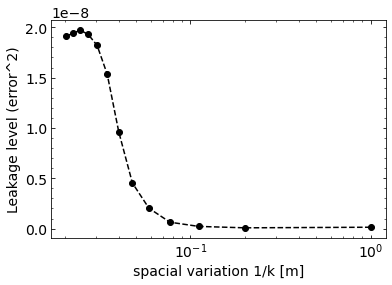

In [30]:
### phase error 0.1
(k,err) = np.loadtxt('Gemmas-CMB/Beam/data/LeakvsK_phase0.1_dk.csv', unpack=True, usecols=(0,1))
x = 1/k # spacial scale corresponding to k_in
print(k, x)
plt.semilogx(x,err,'o--', color='black')
plt.ylabel('Leakage level (error^2)')
plt.xlabel('spacial variation 1/k [m]')
#plt.xlabel('K [1/m]')

## thesis plot - leakage level vs. noise level for different k values

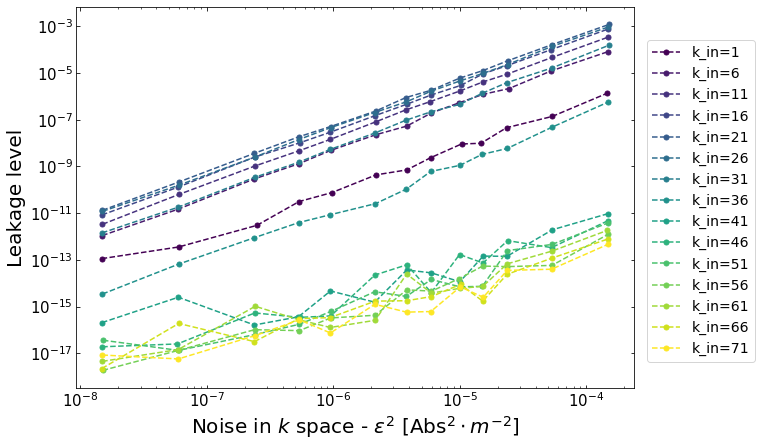

In [17]:
### Fig.9
data = np.loadtxt('Gemmas-CMB/Beam/data/data_k_r2_deg3.csv', unpack=True, usecols=(0,1,2,3))
kin = np.arange(1,72,5) 
cl=mcp.gen_color(cmap="viridis",n=len(kin))
plt.figure(figsize=(10,7))
for i in range(len(kin)):
    each_k = (data[0]==kin[i])
    plt.loglog(data[2][each_k], data[3][each_k],'o--',ms=5, color=cl[i],label='k_in={}'.format(kin[i]))
plt.legend(bbox_to_anchor=(1.01, 0.05),loc="lower left", fontsize = 14)
# plt.xlim(0,10)
# plt.ylim(1e-12,1e-2)
plt.xlabel(r'Noise in $k$ space - $\epsilon^2$ [Abs$^2\cdot m^{-2}$]', fontsize=20)
plt.ylabel('Leakage level', fontsize=20)
#plt.title('width=2')
plt.savefig('/Users/zhaoyuhuai/Desktop/SeniorProj/Thesis/leak_noise_multpleK_h.png',bbox_inches='tight', dpi=600)

## replot with more data points (fix noise level in k space)

[ 1.  4.  7. 10. 13. 16. 19. 22. 25. 28. 31. 34. 37. 40. 43. 46. 49. 52.
 55. 58. 61. 64. 67. 70.] [1.         0.25       0.14285714 0.1        0.07692308 0.0625
 0.05263158 0.04545455 0.04       0.03571429 0.03225806 0.02941176
 0.02702703 0.025      0.02325581 0.02173913 0.02040816 0.01923077
 0.01818182 0.01724138 0.01639344 0.015625   0.01492537 0.01428571]


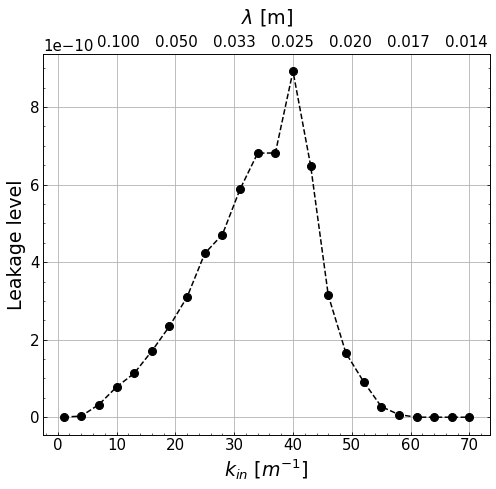

In [69]:
### Fig.10 a
### amplitude errors
(k, err) = np.loadtxt('Gemmas-CMB/Beam/data/LeakvsK_amp0.1.csv', unpack=True, usecols=(0,1))
fig = plt.figure(figsize=(8,7))
x = 1/k # spacial scale corresponding to k_in
print(k, x)

ax1 = fig.add_subplot(1,1,1)
ax2 = ax1.twiny()
ax2.set_xticks([])
ax1.plot(k,err,'o--', ms=8, color='black')
ax1.set_ylabel('Leakage level', fontsize=19)
ax1.set_xlabel(r'$k_{in}$ [$m^{-1}$]', fontsize=19)
ax1.grid()

ax2.xaxis.set_label_coords(.5, 1.08)
ax2.set_xlabel('$\lambda$ [m]', fontsize=19)
plt.text(0.12, 9.55e-10, '0.100')
plt.text(0.25, 9.55e-10, '0.050')
plt.text(0.38, 9.55e-10, '0.033')
plt.text(0.51, 9.55e-10, '0.025')
plt.text(0.64, 9.55e-10, '0.020')
plt.text(0.77, 9.55e-10, '0.017')
plt.text(0.9, 9.55e-10, '0.014')
plt.savefig('/Users/zhaoyuhuai/Desktop/SeniorProj/Thesis/Fixk_amp_h.png', bbox_inches='tight', dpi=600)

[ 1.  4.  7. 10. 13. 16. 19. 22. 25. 28. 31. 34. 37. 40. 43. 46. 49. 52.
 55. 58. 61. 64. 67. 70.] [1.         0.25       0.14285714 0.1        0.07692308 0.0625
 0.05263158 0.04545455 0.04       0.03571429 0.03225806 0.02941176
 0.02702703 0.025      0.02325581 0.02173913 0.02040816 0.01923077
 0.01818182 0.01724138 0.01639344 0.015625   0.01492537 0.01428571]


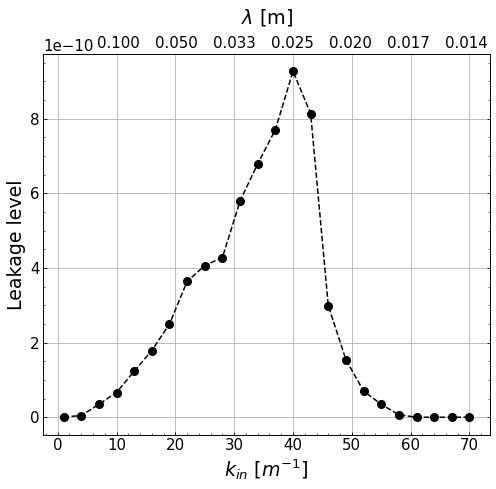

In [70]:
### Fig.10 b
### phase errors
(k, err) = np.loadtxt('Gemmas-CMB/Beam/data/LeakvsK_phase0.1.csv', unpack=True, usecols=(0,1))
fig = plt.figure(figsize=(8,7))
x = 1/k # spacial scale corresponding to k_in
print(k, x)

ax1 = fig.add_subplot(1,1,1)
ax2 = ax1.twiny()
ax2.set_xticks([])
ax1.plot(k,err,'o--', ms=8, color='black')
ax1.set_ylabel('Leakage level', fontsize=19)
ax1.set_xlabel(r'$k_{in}$ [$m^{-1}$]', fontsize=19)
ax1.grid()

ax2.xaxis.set_label_coords(.5, 1.08)
ax2.set_xlabel('$\lambda$ [m]', fontsize=19)
plt.text(0.12, 9.9e-10, '0.100')
plt.text(0.25, 9.9e-10, '0.050')
plt.text(0.38, 9.9e-10, '0.033')
plt.text(0.51, 9.9e-10, '0.025')
plt.text(0.64, 9.9e-10, '0.020')
plt.text(0.77, 9.9e-10, '0.017')
plt.text(0.9, 9.9e-10, '0.014')
plt.savefig('/Users/zhaoyuhuai/Desktop/SeniorProj/Thesis/Fixk_phase_h.png', bbox_inches='tight', dpi=600)

## leakage vs. width of the annulus (fix $k_{in}$ and incease radius)

[ 1.  5.  9. 13. 17. 21. 25. 29. 33. 37. 41. 45. 49. 53. 57. 61. 65. 69.] [1.         0.2        0.11111111 0.07692308 0.05882353 0.04761905
 0.04       0.03448276 0.03030303 0.02702703 0.02439024 0.02222222
 0.02040816 0.01886792 0.01754386 0.01639344 0.01538462 0.01449275]


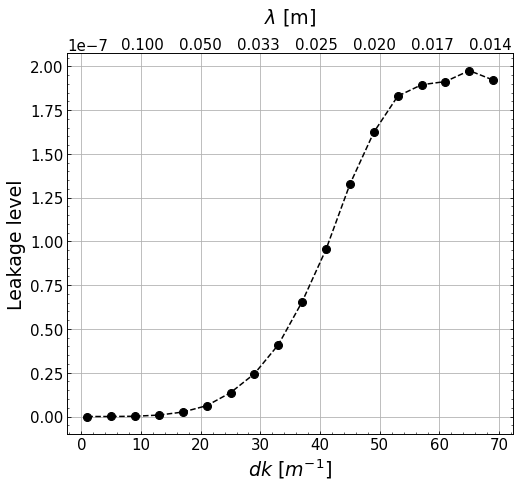

In [79]:
### Fig.11 a
### amplitude errors
(k, err) = np.loadtxt('Gemmas-CMB/Beam/data/LeakvsK_amp0.1_dk.csv', unpack=True, usecols=(0,1))
fig = plt.figure(figsize=(8,7))
x = 1/k # spacial scale corresponding to k_in
print(k, x)

ax1 = fig.add_subplot(1,1,1)
ax2 = ax1.twiny()
ax2.set_xticks([])
ax1.plot(k,err,'o--', ms=8, color='black')
ax1.set_ylabel('Leakage level', fontsize=19)
ax1.set_xlabel(r'$dk$ [$m^{-1}$]', fontsize=19)
ax1.grid()

ax2.xaxis.set_label_coords(.5, 1.08)
ax2.set_xlabel('$\lambda$ [m]', fontsize=19)
plt.text(0.12, 2.1e-7, '0.100')
plt.text(0.25, 2.1e-7, '0.050')
plt.text(0.38, 2.1e-7, '0.033')
plt.text(0.51, 2.1e-7, '0.025')
plt.text(0.64, 2.1e-7, '0.020')
plt.text(0.77, 2.1e-7, '0.017')
plt.text(0.9, 2.1e-7, '0.014')
plt.savefig('/Users/zhaoyuhuai/Desktop/SeniorProj/Thesis/Fixk_dk_amp_h.png', bbox_inches='tight', dpi=600)

[ 1.  5.  9. 13. 17. 21. 25. 29. 33. 37. 41. 45. 49. 53. 57. 61. 65. 69.] [1.         0.2        0.11111111 0.07692308 0.05882353 0.04761905
 0.04       0.03448276 0.03030303 0.02702703 0.02439024 0.02222222
 0.02040816 0.01886792 0.01754386 0.01639344 0.01538462 0.01449275]


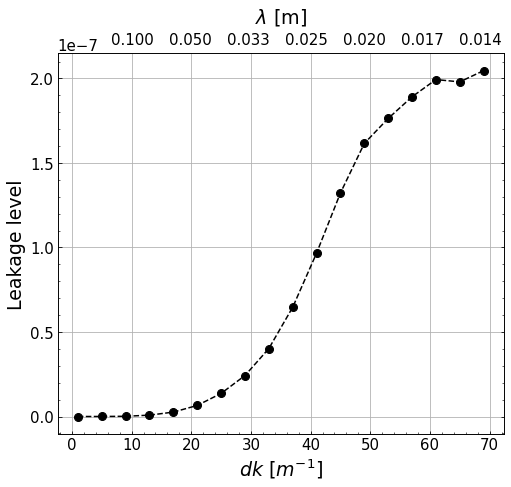

In [80]:
### Fig.11 b
# phase errors
(k, err) = np.loadtxt('Gemmas-CMB/Beam/data/LeakvsK_phase0.1_dk.csv', unpack=True, usecols=(0,1))
fig = plt.figure(figsize=(8,7))
x = 1/k # spacial scale corresponding to k_in
print(k, x)

ax1 = fig.add_subplot(1,1,1)
ax2 = ax1.twiny()
ax2.set_xticks([])
ax1.plot(k,err,'o--', ms=8, color='black')
ax1.set_ylabel('Leakage level', fontsize=19)
ax1.set_xlabel(r'$dk$ [$m^{-1}$]', fontsize=19)
ax1.grid()

ax2.xaxis.set_label_coords(.5, 1.08)
ax2.set_xlabel('$\lambda$ [m]', fontsize=19)
plt.text(0.12, 2.2e-7, '0.100')
plt.text(0.25, 2.2e-7, '0.050')
plt.text(0.38, 2.2e-7, '0.033')
plt.text(0.51, 2.2e-7, '0.025')
plt.text(0.64, 2.2e-7, '0.020')
plt.text(0.77, 2.2e-7, '0.017')
plt.text(0.9, 2.2e-7, '0.014')
plt.savefig('/Users/zhaoyuhuai/Desktop/SeniorProj/Thesis/Fixk_dk_phase_h.png', bbox_inches='tight', dpi=600)

In [88]:
phs = 0.05
lam = 2e-3
k_phot = 2*np.pi/lam
# phs = 2*np.pi*x / lam --> x = lam*phs / 2pi
phs/k_phot

1.5915494309189537e-05